<a href="https://colab.research.google.com/github/CalculatedContent/xgboost2ww/blob/main/notebooks/GoodModelsXGBoost2WW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# xgboost2ww Experiment (50 random models)

This starter notebook trains 50 random XGBoost models and evaluates the result.  

It shows you how to:
1. Pick a “good” XGBoost model using **training-only cross-validation**.
2. Evaluate it on a **true holdout test set** (never used in CV or OOF).
3. Use **xgboost2ww.convert()** to build tiny PyTorch layers for the **W7** (default, recommended matrix)
4. Run **WeightWatcher** to estimate:
   - **α (alpha)**: heavy-tail exponent estimate
   - **traps**: randomization spikes proxy (WeightWatcher diagnostic)

**Note:** For an initial evaluation, you do **not** need `detX=True` in WeightWatcher.

# Set up folder on Google Drive to save final results[link text](https://)

In [4]:

from google.colab import drive
import os
import pandas as pd
from datetime import datetime

# Mount Drive
drive.mount("/content/drive", force_remount=False)

# Create output folder
GDRIVE_DIR = "/content/drive/MyDrive/xgboost2ww_runs"
os.makedirs(GDRIVE_DIR, exist_ok=True)

Mounted at /content/drive


# Install dependencies

In [5]:
!pip -q install "pandas==2.2.2" xgboost weightwatcher scikit-learn openml scipy pyarrow
!apt-get -qq update && apt-get -qq install -y git

# Clone + install xgboost2ww (public repo)
!pip install xgboost2ww

import xgboost2ww
print("xgboost2ww loaded from:", getattr(xgboost2ww, "__file__", None))

from xgboost2ww import convert
print("Imported xgboost2ww.convert OK")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 44.5 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
xgboost2ww loaded from: /usr/local/lib/python3.12/dist-packages/xgboost2ww/__init__.py
Imported xgboost2ww.convert OK


## Imports and settings

We’ll run a small starter experiment over a handful of OpenML binary datasets.

Key settings:
- `TARGET_DATASETS`: how many datasets to run (starter: 10)
- `NFOLDS`: OOF folds for xgboost2ww matrices
- `T_TRAJ`: how many trajectory points along boosting to sample

In [6]:
import warnings, time
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xgboost as xgb
import openml

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import torch
import weightwatcher as ww

# Reproducibility
RNG = 0
rng = np.random.default_rng(RNG)

# Starter run size
TARGET_DATASETS = 100

# Train/test split (true holdout)
TEST_SIZE = 0.20

# OOF matrix construction
NFOLDS = 5
T_TRAJ = 160

# Data cap + safety guard
MAX_OPENML_ROWS = 60000
MAX_FEATURES_GUARD = 50_000

# “Good model” selection (training-only CV)
GOOD_TRIALS = 5
CV_MAX_ROUNDS = 3000
CV_EARLY_STOP = 150
MIN_GOOD_TEST_ACC = 0.75

# OpenML suites to pull datasets from
SUITE_IDS = [14, 99, 225]

## Optional: GPU detection for XGBoost

If a GPU is available, we’ll use XGBoost’s `gpu_hist` for faster training.
If not, we fall back to CPU `hist`.

In [7]:
def xgb_gpu_available() -> bool:
    try:
        Xtmp = np.random.randn(256, 8).astype(np.float32)
        ytmp = (Xtmp[:, 0] > 0).astype(np.int32)
        dtmp = xgb.DMatrix(Xtmp, label=ytmp)
        params = dict(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="gpu_hist",
            predictor="gpu_predictor",
            max_depth=2,
            learning_rate=0.2,
            seed=RNG,
        )
        _ = xgb.train(params=params, dtrain=dtmp, num_boost_round=5, verbose_eval=False)
        return True
    except Exception:
        return False

USE_GPU = xgb_gpu_available()
print("XGBoost GPU available:", USE_GPU)

XGBoost GPU available: False




```
## Load OpenML binary datasets (with preprocessing)

We:
- Keep only **binary** classification datasets
- One-hot encode categorical features
- Impute missing values
- Optionally cap dataset size (`MAX_OPENML_ROWS`) for speed
```



In [8]:
def factorize_binary(y_raw):
    y_codes, uniques = pd.factorize(y_raw)
    if len(uniques) != 2:
        return None
    return y_codes.astype(int)

def make_preprocessor(Xdf: pd.DataFrame):
    cat_cols = Xdf.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    num_cols = [c for c in Xdf.columns if c not in cat_cols]
    transformers = []
    if len(num_cols):
        transformers.append(("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols))
    if len(cat_cols):
        transformers.append(("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
        ]), cat_cols))
    if not transformers:
        raise ValueError("no usable columns")
    return ColumnTransformer(transformers=transformers, remainder="drop", sparse_threshold=0.3)

def enumerate_openml_dataset_ids_from_suites(suite_ids):
    ids, seen = [], set()
    for sid in suite_ids:
        suite = openml.study.get_suite(sid)
        for did in suite.data:
            did = int(did)
            if did not in seen:
                ids.append(did)
                seen.add(did)
    return ids

def load_openml_dataset_by_id(did: int):
    ds = openml.datasets.get_dataset(did)
    target = ds.default_target_attribute
    Xdf, y_raw, _, _ = ds.get_data(dataset_format="dataframe", target=target)

    y = factorize_binary(y_raw)
    if y is None:
        return None

    if MAX_OPENML_ROWS is not None and len(Xdf) > MAX_OPENML_ROWS:
        take = rng.choice(len(Xdf), size=MAX_OPENML_ROWS, replace=False)
        Xdf = Xdf.iloc[take].reset_index(drop=True)
        y = y[take]

    pre = make_preprocessor(Xdf)
    X = pre.fit_transform(Xdf)
    return X, y.astype(int), ds.name, did

## Pick a “good” XGBoost model using training-only CV

For each dataset:
1. Split into **train/test**
2. Run CV on the **train only** set to pick hyperparameters + early-stopping rounds
3. Train a final model on train
4. Evaluate once on the holdout test set

We keep only datasets where the holdout test accuracy is at least `MIN_GOOD_TEST_ACC`.

In [9]:
def pick_good_params_via_cv(Xtr, ytr, nfold=5, *, dataset_id: int):
    dtrain = xgb.DMatrix(Xtr, label=ytr)
    local_rng = np.random.default_rng(RNG + int(dataset_id))  # stable across runs

    best = None
    best_score = np.inf

    for _ in range(GOOD_TRIALS):
        params = dict(
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            seed=RNG,
            learning_rate=float(10 ** local_rng.uniform(-2.0, -0.6)),   # 0.01..0.25
            max_depth=int(local_rng.integers(2, 7)),
            min_child_weight=float(10 ** local_rng.uniform(0.0, 2.0)),  # 1..100
            subsample=float(local_rng.uniform(0.6, 0.9)),
            colsample_bytree=float(local_rng.uniform(0.6, 0.9)),
            reg_lambda=float(10 ** local_rng.uniform(0.0, 2.0)),        # 1..100
            gamma=float(local_rng.uniform(0.0, 0.5)),
        )
        if USE_GPU:
            params["tree_method"] = "gpu_hist"
            params["predictor"] = "gpu_predictor"

        cv = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=CV_MAX_ROUNDS,
            nfold=nfold,
            stratified=True,
            early_stopping_rounds=CV_EARLY_STOP,
            seed=RNG,
            verbose_eval=False,
        )

        score = float(cv["test-logloss-mean"].iloc[-1])
        rounds = int(len(cv))
        if score < best_score:
            best_score = score
            best = (params, rounds, score)

    return best  # (params, rounds, cv_logloss)

def train_eval_fulltrain(Xtr, ytr, Xte, yte, params, rounds):
    dtr = xgb.DMatrix(Xtr, label=ytr)
    dte = xgb.DMatrix(Xte, label=yte)

    bst = xgb.train(params=params, dtrain=dtr, num_boost_round=rounds, verbose_eval=False)

    m_tr = bst.predict(dtr, output_margin=True).astype(np.float32)
    p_tr = 1.0 / (1.0 + np.exp(-m_tr))
    train_acc = float(accuracy_score(ytr, (p_tr >= 0.5).astype(int)))

    m_te = bst.predict(dte, output_margin=True).astype(np.float32)
    p_te = 1.0 / (1.0 + np.exp(-m_te))
    test_acc = float(accuracy_score(yte, (p_te >= 0.5).astype(int)))
    test_loss = float(log_loss(yte, np.vstack([1 - p_te, p_te]).T, labels=[0, 1]))

    return train_acc, test_acc, test_loss, bst

## WeightWatcher helper

We use WeightWatcher on the PyTorch layer returned by `xgboost2ww.convert()`.

For a first pass, we run:

`watcher.analyze(randomize=True, ERG=True, plot=False)`

No `detX=True` needed for initial evaluation.

In [10]:
def ww_metrics_from_layer(layer):
    watcher = ww.WeightWatcher(model=layer)
    details_df = watcher.analyze(randomize=True, ERG=True, plot=False)  # starter: no detX
    alpha = float(details_df["alpha"].iloc[0]) if "alpha" in details_df.columns else np.nan
    traps = float(details_df["num_traps"].iloc[0]) if "rand_num_spikes" in details_df.columns else np.nan
    ERG_gap = float(details_df["ERG_gap"].iloc[0]) if "ERG_gap" in details_df.columns else np.nan
    return alpha, traps, ERG_gap

## Run the experiment (first 10 datasets)

For each dataset, we compute α/traps for **W7**.

Key reproducibility detail:
- We pass `train_params=good_params` and `num_boost_round=good_rounds` into `convert()`
- That ensures the fold-training used to compute OOF increments matches the chosen model configuration.

In [11]:
# ============================================================
# MAIN LOOP — Compute W7 ONLY using xgboost2ww.convert()
# Memory-safe version:
#   - keep sparse when possible (XGBoost supports CSR)
#   - avoid densifying big one-hot matrices
#   - use float32
#   - hard guards + cleanup
# ============================================================

import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

rows = []
kept = 0

# If you ever densify, this is the real RAM killer.
# 2e8 float32 ~ 0.8GB. float64 would be ~1.6GB.
MAX_DENSE_ELEMENTS = int(2e8)

dataset_ids = enumerate_openml_dataset_ids_from_suites(SUITE_IDS)
t0 = time.time()

for did in dataset_ids:
    if kept >= TARGET_DATASETS:
        break

    loaded = load_openml_dataset_by_id(int(did))
    if loaded is None:
        continue

    X, y, name, did_loaded = loaded

    # ---- Feature guard (still useful, but not sufficient alone)
    if int(X.shape[1]) > MAX_FEATURES_GUARD:
        continue

    # -----------------------------
    # True holdout split
    # -----------------------------
    tr_idx, te_idx = train_test_split(
        np.arange(len(y)),
        test_size=TEST_SIZE,
        random_state=RNG,
        stratify=y
    )

    Xtr = X[tr_idx]
    Xte = X[te_idx]
    ytr = y[tr_idx]
    yte = y[te_idx]

    # -----------------------------
    # Keep sparse if sparse; cast to float32 if dense
    # -----------------------------
    is_sparse = hasattr(Xtr, "tocoo")  # works for scipy sparse matrices

    if not is_sparse:
        # Dense path: force 2D arrays and float32
        Xtr = np.asarray(Xtr, dtype=np.float32)
        Xte = np.asarray(Xte, dtype=np.float32)

        if Xtr.ndim != 2:
            print("SKIP: unexpected Xtr shape:", getattr(Xtr, "shape", None))
            continue
    else:
        # Sparse path: DO NOT densify for CV/training
        # Convert to CSR once (fast row slicing + DMatrix friendly)
        Xtr = Xtr.tocsr()
        Xte = Xte.tocsr()

        # OPTIONAL: you may also enforce float32 data in CSR
        # (scipy sparse supports astype efficiently)
        try:
            Xtr = Xtr.astype(np.float32)
            Xte = Xte.astype(np.float32)
        except Exception:
            pass

        # HARD guard: if someone later tries to densify, estimate cost
        dense_cost = int(Xtr.shape[0]) * int(Xtr.shape[1])
        if dense_cost > MAX_DENSE_ELEMENTS:
            # We can still train XGBoost on sparse,
            # but convert() might require dense -> likely OOM.
            # Safer to skip early unless you have a sparse-aware convert().
            print(
                f"SKIP: sparse would densify too big: "
                f"n_train={Xtr.shape[0]}, d={Xtr.shape[1]}, "
                f"elements={dense_cost:,}"
            )
            # cleanup
            del X, y, Xtr, Xte, ytr, yte
            gc.collect()
            continue

    # -----------------------------
    # Select "good" hyperparameters (train-only CV)
    # -----------------------------
    good_params, good_rounds, good_cv_logloss = pick_good_params_via_cv(
        Xtr, ytr, nfold=NFOLDS, dataset_id=int(did_loaded)
    )

    # Train final model and evaluate on holdout
    good_train_acc, good_test_acc, good_test_loss, bst = train_eval_fulltrain(
        Xtr, ytr, Xte, yte, good_params, good_rounds
    )

    if good_test_acc < MIN_GOOD_TEST_ACC:
        # cleanup
        del bst, X, y, Xtr, Xte, ytr, yte
        gc.collect()
        continue

    # ============================================================
    # Compute W7 using xgboost2ww.convert()
    # ============================================================
    try:
        # If convert() can accept CSR directly, great.
        # If it cannot, this will throw and we skip cleanly.
        layer_W7 = convert(
            model=bst,
            data=Xtr,
            labels=ytr,
            W="W7",
            nfolds=NFOLDS,
            t_points=T_TRAJ,
            random_state=RNG,
            train_params=good_params,
            num_boost_round=good_rounds,
            multiclass="error",
            return_type="torch",
            verbose=False,
        )
    except Exception as e:
        print("SKIP during convert():", type(e).__name__, e)
        # cleanup
        del bst, X, y, Xtr, Xte, ytr, yte
        gc.collect()
        continue

    # WeightWatcher structural diagnostics
    alpha_W7, traps_W7, ERG_gap_W7 = ww_metrics_from_layer(layer_W7)

    rows.append(dict(
        openml_id=int(did_loaded),
        dataset=name,
        n_rows_total=int(X.shape[0]),
        n_train=int(Xtr.shape[0]),
        n_test=int(Xte.shape[0]),
        n_features=int(X.shape[1]),
        rounds=int(good_rounds),
        cv_logloss=float(good_cv_logloss),
        good_train_acc=float(good_train_acc),
        good_test_acc=float(good_test_acc),
        good_test_loss=float(good_test_loss),
        alpha_W7=float(alpha_W7),
        traps_W7=float(traps_W7),
        ERG_gap_W7=float(ERG_gap_W7),
    ))

    kept += 1
    elapsed = (time.time() - t0) / 60.0

    print(
        f"[{kept}/{TARGET_DATASETS}] {name} (OpenML {did_loaded}) "
        f"| train/test={good_train_acc:.3f}/{good_test_acc:.3f} "
        f"| α(W7)={alpha_W7:.2f} traps(W7)={traps_W7:.1f} "
        f"| elapsed={elapsed:.1f} min",
        flush=True
    )

    # cleanup big objects each iteration
    del bst, layer_W7, X, y, Xtr, Xte, ytr, yte
    gc.collect()

df_good = pd.DataFrame(rows)

print(f"\nDONE. datasets_kept={df_good['openml_id'].nunique()} rows={len(df_good)}")
df_good

[1/100] kr-vs-kp (OpenML 3) | train/test=0.995/0.986 | α(W7)=2.28 traps(W7)=0.0 | elapsed=1.5 min
[2/100] breast-w (OpenML 15) | train/test=0.977/0.979 | α(W7)=1.94 traps(W7)=2.0 | elapsed=1.9 min
SKIP during convert(): IndexError tuple index out of range
[3/100] credit-approval (OpenML 29) | train/test=0.918/0.870 | α(W7)=3.16 traps(W7)=0.0 | elapsed=4.2 min
[4/100] credit-g (OpenML 31) | train/test=0.873/0.750 | α(W7)=3.87 traps(W7)=0.0 | elapsed=4.3 min
[5/100] diabetes (OpenML 37) | train/test=0.842/0.766 | α(W7)=2.32 traps(W7)=0.0 | elapsed=4.7 min
[6/100] spambase (OpenML 44) | train/test=0.982/0.953 | α(W7)=3.10 traps(W7)=0.0 | elapsed=6.0 min
[7/100] tic-tac-toe (OpenML 50) | train/test=0.999/0.990 | α(W7)=2.65 traps(W7)=0.0 | elapsed=6.6 min
[8/100] electricity (OpenML 151) | train/test=0.948/0.905 | α(W7)=2.49 traps(W7)=0.0 | elapsed=14.7 min
[9/100] sick (OpenML 38) | train/test=0.992/0.985 | α(W7)=2.09 traps(W7)=0.0 | elapsed=15.3 min
[10/100] scene (OpenML 312) | train/tes

[39/100] Internet-Advertisements (OpenML 1176) | train/test=0.989/0.966 | α(W7)=2.28 traps(W7)=0.0 | elapsed=123.4 min
[40/100] PhishingWebsites (OpenML 4534) | train/test=0.988/0.964 | α(W7)=2.24 traps(W7)=0.0 | elapsed=126.6 min
SKIP: sparse would densify too big: n_train=26215, d=15626, elements=409,635,590
[41/100] Australian (OpenML 40509) | train/test=0.940/0.877 | α(W7)=2.97 traps(W7)=0.0 | elapsed=127.2 min
SKIP during convert(): IndexError tuple index out of range
[42/100] climate-model-simulation-crashes (OpenML 40994) | train/test=0.998/0.972 | α(W7)=2.87 traps(W7)=0.0 | elapsed=136.6 min
[43/100] wilt (OpenML 40983) | train/test=0.995/0.983 | α(W7)=2.10 traps(W7)=0.0 | elapsed=137.2 min
[44/100] Internet-Advertisements (OpenML 40978) | train/test=0.986/0.966 | α(W7)=2.26 traps(W7)=0.0 | elapsed=162.9 min
[45/100] churn (OpenML 40701) | train/test=0.973/0.948 | α(W7)=3.69 traps(W7)=0.0 | elapsed=163.7 min

DONE. datasets_kept=45 rows=45


,openml_id,dataset,n_rows_total,n_train,n_test,n_features,rounds,cv_logloss,good_train_acc,good_test_acc,good_test_loss,alpha_W7,traps_W7,ERG_gap_W7
0,3,kr-vs-kp,3196,2556,640,73,3000,0.048728,0.995305,0.985938,0.040080,2.277884,0.0,52.0
1,15,breast-w,699,559,140,9,614,0.104420,0.976744,0.978571,0.095988,1.942219,2.0,36.0
2,29,credit-approval,690,552,138,46,484,0.325342,0.918478,0.869565,0.238881,3.160724,0.0,76.0
3,31,credit-g,1000,800,200,61,423,0.479623,0.872500,0.750000,0.495178,3.865018,0.0,101.0
4,37,diabetes,768,614,154,8,863,0.486438,0.842020,0.766234,0.451021,2.323300,0.0,49.0
5,44,spambase,4601,3680,921,57,172,0.135285,0.982065,0.953312,0.119519,3.097385,0.0,83.0
6,50,tic-tac-toe,958,766,192,27,3000,0.096515,0.998695,0.989583,0.064514,2.653533,0.0,67.0
7,151,electricity,45312,36249,9063,14,3000,0.242747,0.947778,0.905219,0.224747,2.493329,0.0,-56.0
8,38,sick,3772,3017,755,53,537,0.051678,0.992045,0.985430,0.047627,2.090145,0.0,43.0
9,312,scene,2407,1925,482,304,2750,0.113485,0.995325,0.975104,0.082742,2.191690,0.0,43.0


## Plots

These quick plots help you sanity-check:
- α values across datasets for the W7 (default) matrix
- traps across datasets for the W7 (default) matrix
- relationship between holdout accuracy and α(W7)

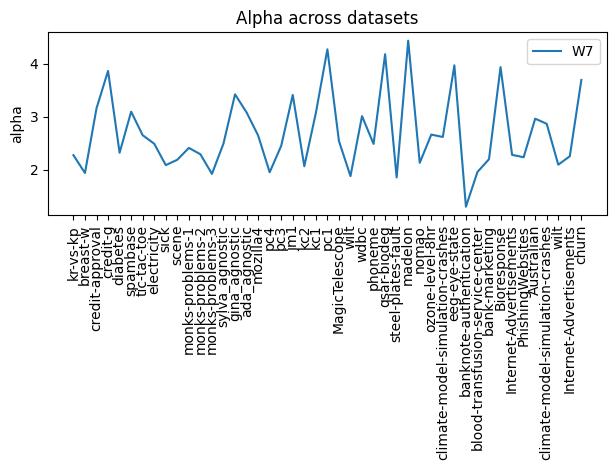

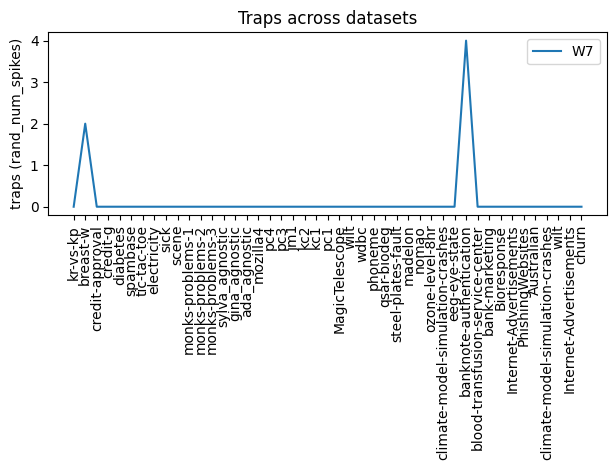

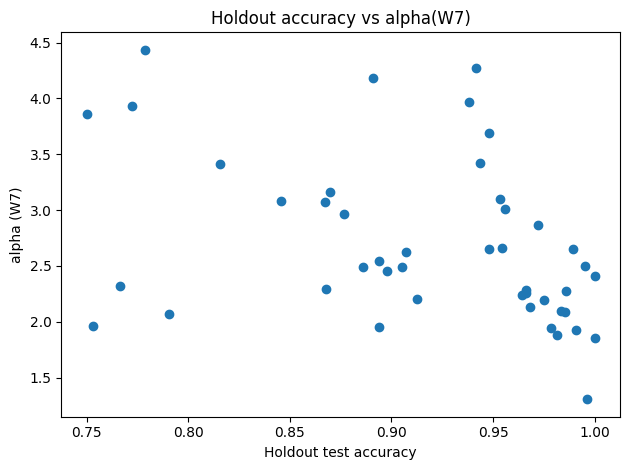

In [12]:
import matplotlib.pyplot as plt

if len(df_good) == 0:
    print("No datasets kept. Try lowering MIN_GOOD_TEST_ACC.")
else:
    x = np.arange(len(df_good))

    # Alpha across datasets
    plt.figure()
    plt.plot(x, df_good["alpha_W7"].values, label="W7")
    plt.xticks(x, df_good["dataset"].values, rotation=90)
    plt.ylabel("alpha")
    plt.title("Alpha across datasets")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Traps across datasets
    plt.figure()
    plt.plot(x, df_good["traps_W7"].values, label="W7")
    plt.xticks(x, df_good["dataset"].values, rotation=90)
    plt.ylabel("traps (rand_num_spikes)")
    plt.title("Traps across datasets")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Holdout accuracy vs alpha(W7)
    plt.figure()
    plt.scatter(df_good["good_test_acc"].values, df_good["alpha_W7"].values)
    plt.xlabel("Holdout test accuracy")
    plt.ylabel("alpha (W7)")
    plt.title("Holdout accuracy vs alpha(W7)")
    plt.tight_layout()
    plt.show()

## Additional structural diagnostics

We now visualize the distribution of:

- alpha(W7)
- traps(W7)
- ERG_gap(W7)

and examine the structural relationship between:

alpha(W7) and ERG_gap(W7)

This helps understand how scale invariance and the ERG determinant condition co-vary across models.

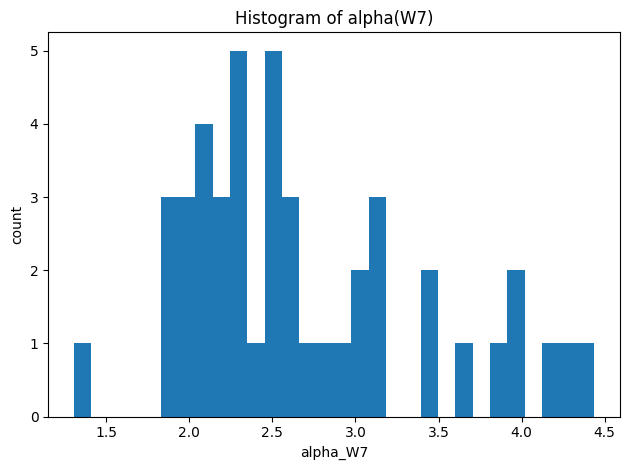

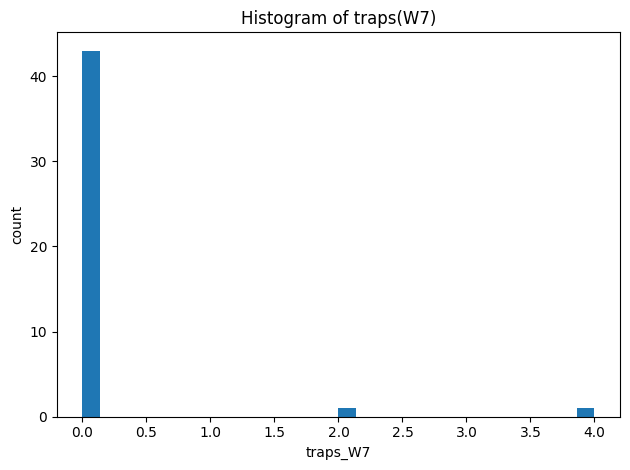

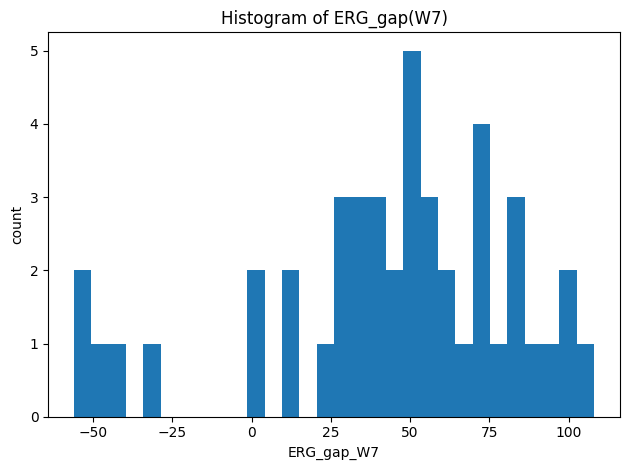

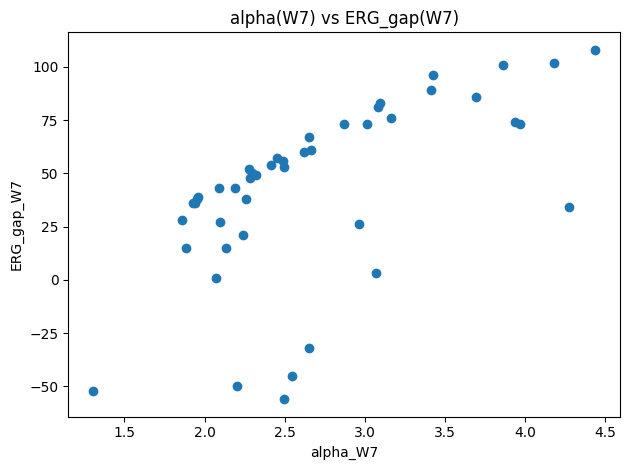

In [13]:
import matplotlib.pyplot as plt
import numpy as np

if len(df_good) == 0:
    print("No results to plot.")
else:

    # -------------------------
    # Histogram: alpha_W7
    # -------------------------
    plt.figure()
    plt.hist(df_good["alpha_W7"].dropna().values, bins=30)
    plt.xlabel("alpha_W7")
    plt.ylabel("count")
    plt.title("Histogram of alpha(W7)")
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Histogram: traps_W7
    # -------------------------
    plt.figure()
    plt.hist(df_good["traps_W7"].dropna().values, bins=30)
    plt.xlabel("traps_W7")
    plt.ylabel("count")
    plt.title("Histogram of traps(W7)")
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Histogram: ERG_gap_W7
    # -------------------------
    plt.figure()
    plt.hist(df_good["ERG_gap_W7"].dropna().values, bins=30)
    plt.xlabel("ERG_gap_W7")
    plt.ylabel("count")
    plt.title("Histogram of ERG_gap(W7)")
    plt.tight_layout()
    plt.show()

    # -------------------------
    # Scatter: alpha vs ERG_gap
    # -------------------------
    plt.figure()
    plt.scatter(
        df_good["alpha_W7"].values,
        df_good["ERG_gap_W7"].values
    )
    plt.xlabel("alpha_W7")
    plt.ylabel("ERG_gap_W7")
    plt.title("alpha(W7) vs ERG_gap(W7)")
    plt.tight_layout()
    plt.show()

In [14]:

# Timestamped filename so we never overwrite runs
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
RESULTS_FEATHER = os.path.join(GDRIVE_DIR, f"W7_results_{ts}.feather")

# Convert + save
df_good = pd.DataFrame(rows)
df_good.to_feather(RESULTS_FEATHER)

print(f"Saved {len(df_good)} rows to:")
print(RESULTS_FEATHER)

df_good.head()

Saved 45 rows to:
/content/drive/MyDrive/xgboost2ww_runs/W7_results_20260222_082306.feather


,openml_id,dataset,n_rows_total,n_train,n_test,n_features,rounds,cv_logloss,good_train_acc,good_test_acc,good_test_loss,alpha_W7,traps_W7,ERG_gap_W7
0,3,kr-vs-kp,3196,2556,640,73,3000,0.048728,0.995305,0.985938,0.040080,2.277884,0.0,52.0
1,15,breast-w,699,559,140,9,614,0.104420,0.976744,0.978571,0.095988,1.942219,2.0,36.0
2,29,credit-approval,690,552,138,46,484,0.325342,0.918478,0.869565,0.238881,3.160724,0.0,76.0
3,31,credit-g,1000,800,200,61,423,0.479623,0.872500,0.750000,0.495178,3.865018,0.0,101.0
4,37,diabetes,768,614,154,8,863,0.486438,0.842020,0.766234,0.451021,2.323300,0.0,49.0


# RELOAD data fron Google Drive and plot

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading: /content/drive/MyDrive/xgboost2ww_runs/W7_results_20260222_082306.feather
Rows: 45 | Cols: 14


,openml_id,dataset,n_rows_total,n_train,n_test,n_features,rounds,cv_logloss,good_train_acc,good_test_acc,good_test_loss,alpha_W7,traps_W7,ERG_gap_W7
0,3,kr-vs-kp,3196,2556,640,73,3000,0.048728,0.995305,0.985938,0.040080,2.277884,0.0,52.0
1,15,breast-w,699,559,140,9,614,0.104420,0.976744,0.978571,0.095988,1.942219,2.0,36.0
2,29,credit-approval,690,552,138,46,484,0.325342,0.918478,0.869565,0.238881,3.160724,0.0,76.0
3,31,credit-g,1000,800,200,61,423,0.479623,0.872500,0.750000,0.495178,3.865018,0.0,101.0
4,37,diabetes,768,614,154,8,863,0.486438,0.842020,0.766234,0.451021,2.323300,0.0,49.0
5,44,spambase,4601,3680,921,57,172,0.135285,0.982065,0.953312,0.119519,3.097385,0.0,83.0
6,50,tic-tac-toe,958,766,192,27,3000,0.096515,0.998695,0.989583,0.064514,2.653533,0.0,67.0
7,151,electricity,45312,36249,9063,14,3000,0.242747,0.947778,0.905219,0.224747,2.493329,0.0,-56.0
8,38,sick,3772,3017,755,53,537,0.051678,0.992045,0.985430,0.047627,2.090145,0.0,43.0
9,312,scene,2407,1925,482,304,2750,0.113485,0.995325,0.975104,0.082742,2.191690,0.0,43.0


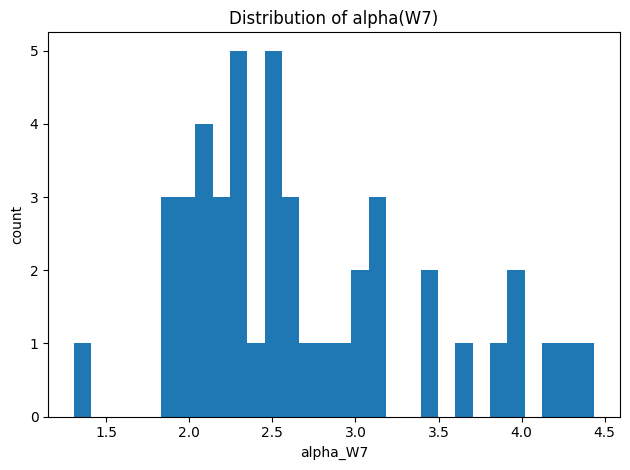

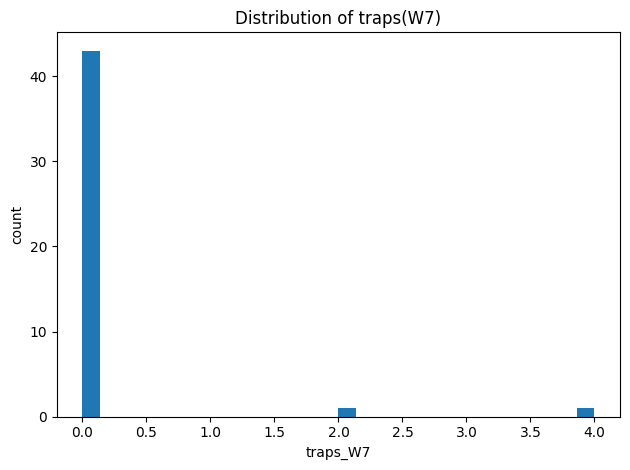

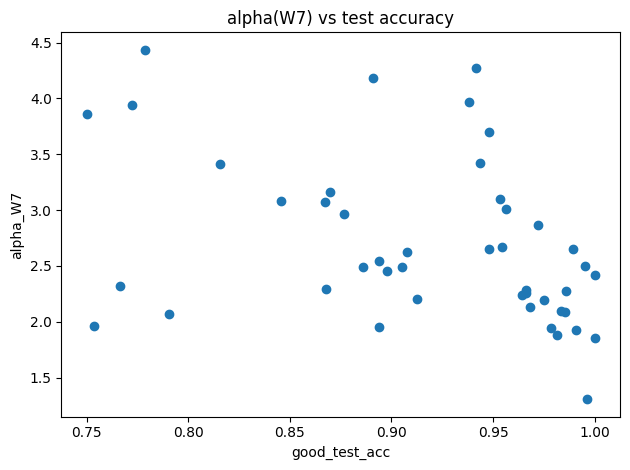

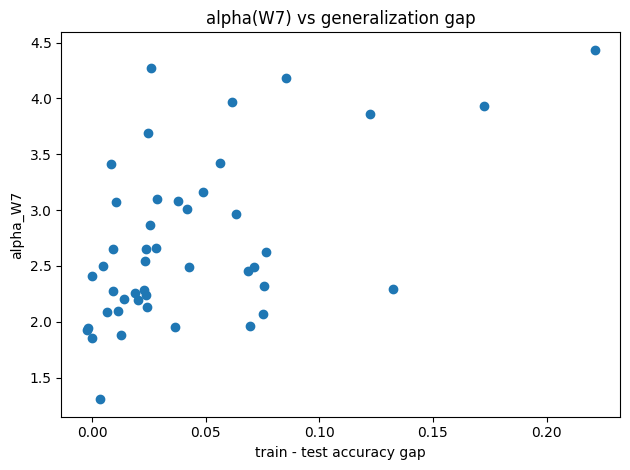

Top 15 by test accuracy:


,dataset,openml_id,good_train_acc,good_test_acc,alpha_W7,traps_W7,rounds
10,monks-problems-1,333,1.000000,1.000000,2.414671,0.0,1460
28,steel-plates-fault,1504,1.000000,1.000000,1.857983,0.0,3000
34,banknote-authentication,1462,1.000000,0.996364,1.306701,4.0,1540
13,sylva_agnostic,1036,0.999826,0.995137,2.498243,0.0,320
12,monks-problems-3,335,0.988713,0.990991,1.924780,0.0,1478
6,tic-tac-toe,50,0.998695,0.989583,2.653533,0.0,3000
0,kr-vs-kp,3,0.995305,0.985938,2.277884,0.0,3000
8,sick,38,0.992045,0.985430,2.090145,0.0,537
42,wilt,40983,0.995092,0.983471,2.098898,0.0,881
24,wilt,1570,0.994317,0.981405,1.882993,0.0,2699


In [15]:
# ============================================
# Load results from Google Drive + plot
# (single Colab cell)
# ============================================

from google.colab import drive
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

drive.mount("/content/drive", force_remount=False)

GDRIVE_DIR = "/content/drive/MyDrive/xgboost2ww_runs"

# Load the most recent results file by default
files = sorted(glob.glob(os.path.join(GDRIVE_DIR, "W7_results_*.feather")))
if not files:
    raise FileNotFoundError(f"No W7_results_*.feather files found in {GDRIVE_DIR}")

RESULTS_FEATHER = files[-1]
print("Loading:", RESULTS_FEATHER)

df = pd.read_feather(RESULTS_FEATHER)
print("Rows:", len(df), "| Cols:", len(df.columns))
display(df.head(10))

# ---- Basic cleanup / sort
if "test_acc" in df.columns:
    df = df.sort_values("test_acc", ascending=False)
elif "good_test_acc" in df.columns:
    df = df.sort_values("good_test_acc", ascending=False)

# ---- Choose column names (supports both naming styles)
alpha_col = "alpha_W7" if "alpha_W7" in df.columns else "alpha"
traps_col = "traps_W7" if "traps_W7" in df.columns else "traps"
test_col  = "test_acc" if "test_acc" in df.columns else ("good_test_acc" if "good_test_acc" in df.columns else None)
train_col = "train_acc" if "train_acc" in df.columns else ("good_train_acc" if "good_train_acc" in df.columns else None)

# ---- Plot 1: alpha_W7 distribution
plt.figure()
plt.hist(df[alpha_col].dropna().values, bins=30)
plt.title("Distribution of alpha(W7)")
plt.xlabel("alpha_W7")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# ---- Plot 2: traps_W7 distribution
plt.figure()
plt.hist(df[traps_col].dropna().values, bins=30)
plt.title("Distribution of traps(W7)")
plt.xlabel("traps_W7")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# ---- Plot 3: alpha(W7) vs test accuracy
if test_col is not None:
    plt.figure()
    plt.scatter(df[test_col].values, df[alpha_col].values)
    plt.xlabel(test_col)
    plt.ylabel(alpha_col)
    plt.title("alpha(W7) vs test accuracy")
    plt.tight_layout()
    plt.show()

# ---- Plot 4: train-test gap vs alpha(W7) (if train exists)
if test_col is not None and train_col is not None:
    gap = df[train_col].values - df[test_col].values
    plt.figure()
    plt.scatter(gap, df[alpha_col].values)
    plt.xlabel("train - test accuracy gap")
    plt.ylabel(alpha_col)
    plt.title("alpha(W7) vs generalization gap")
    plt.tight_layout()
    plt.show()

# ---- Quick summary table
summary_cols = [c for c in ["dataset","openml_id",train_col,test_col,alpha_col,traps_col,"rounds"] if c and c in df.columns]
print("Top 15 by test accuracy:")
display(df[summary_cols].head(15))